In [1]:
import os
import glob
import shutil


import pandas as pd
from tqdm.auto import tqdm

# Load from JSON files

- automatically unzips the files exported from CVAT

### Unzip the exported files

In [2]:
# Directory that contains zip files of CVAT exports in COCO format
cvat_dir = '/data/db/MWSLab-2023/scoutexports'

In [3]:
!ls {cvat_dir}

A2left.zip		      NG25right2.zip		     SH04.zip
A2right.zip		      NG25right3.zip		     SH05.zip
A2scout-export-images.csv     NG25scout-export-images.csv    SH06.zip
DANgtscout-export-images.csv  NG26GTscout-export-images.csv  SH07.zip
DANleft.zip		      NG26MLscout-export-images.csv  SH08.zip
DANright.zip		      NG26left1.zip		     SH09.zip
MTbRight.zip		      NG26left2.zip		     SH10.zip
MTbleft.zip		      NG26left3.zip		     SH11.zip
MTleft.zip		      NG26right1.zip		     SH12.zip
MTright.zip		      NG26right2.zip		     SH13.zip
MTscout-export-images.csv     NG26right3.zip		     SH14.zip
NG25left1.zip		      NG26scout-export-images.csv    SH15.zip
NG25left2.zip		      SH01.zip			     _archive
NG25left3.zip		      SH02.zip			     repeats
NG25right1.zip		      SH03.zip


In [4]:
zip_paths = glob.glob(f'{cvat_dir}/*.zip')

In [5]:
extracted_path = 'extracted'

In [6]:
!mkdir {extracted_path}

mkdir: cannot create directory ‘extracted’: File exists


In [7]:
import zipfile
import os

def unzip_to_same_named_folder(zip_file_path, target_directory):
    # Extract the directory name from the zip file name
    zip_directory_name = os.path.splitext(os.path.basename(zip_file_path))[0]
    final_target_directory = os.path.join(target_directory, zip_directory_name)

    # Create the target directory if it doesn't exist
    if not os.path.exists(final_target_directory):
        os.makedirs(final_target_directory)

    # Unzip the file into the specified directory
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(final_target_directory)

    return final_target_directory

# Example usage

for zip_file_path in tqdm(zip_paths):
    target_directory = extracted_path
    unzipped_directory = unzip_to_same_named_folder(zip_file_path, target_directory)
    print(unzipped_directory)

  0%|          | 0/35 [00:00<?, ?it/s]

extracted/NG25right2
extracted/SH07
extracted/SH10
extracted/NG26right2
extracted/SH14
extracted/A2left
extracted/SH03
extracted/SH08
extracted/MTbRight
extracted/SH11
extracted/SH02
extracted/MTleft
extracted/NG25right1
extracted/SH15
extracted/A2right
extracted/NG25left2
extracted/NG25left1
extracted/NG26left3
extracted/NG25left3
extracted/NG26left1
extracted/MTbleft
extracted/SH12
extracted/SH13
extracted/NG26left2
extracted/NG25right3
extracted/NG26right1
extracted/DANleft
extracted/MTright
extracted/SH09
extracted/SH01
extracted/SH05
extracted/SH06
extracted/SH04
extracted/NG26right3
extracted/DANright


In [8]:
anno_paths = glob.glob(f'{extracted_path}/*/*/*.json')

In [9]:
import json

def load_json(file_path):
    with open(file_path) as f:
        data = json.load(f)
    return data

### Read unzipped files and preproess 

- Modifies each annotation ID to be a combination of filename and original ID to avoid duplicates
- Modifies each image ID to be a combination of filename and original ID to avoid duplicates
- Creates the 'species' text field from category ids
- Builds paths to image subfolders

In [10]:
# A hierarchical directory of images
img_dir = '/data/kaza1'


dfs = []
dfas = []
dfis = []
for anno_path in anno_paths:
    data = load_json(anno_path)

    dfa = pd.DataFrame(data['annotations'])
    dfi = pd.DataFrame(data['images'])

    folder_name = anno_path.split('/')[-3]
    
    cat_list = data['categories']
    cat_map = {item['id']: item['name'] for item in cat_list}
    dfa['species'] = dfa['category_id'].map(cat_map)
    
    dfa['id'] = folder_name + '_' + dfa['id'].astype(str)
    dfa['image_id'] = folder_name + '_' + dfa['image_id'].astype(str)
    dfi['id'] = folder_name + '_' + dfi['id'].astype(str)
    
    dfi['folder_name'] = dfi['file_name'].apply(lambda x: x.split('-')[0] + '_' + x.split('-')[1].split('_')[-1])
    dfi['subfolder_name'] = dfi['file_name'].apply(lambda x: '-'.join(x.split('-')[:2]))
    dfi['file_path'] = img_dir + '/' + dfi['folder_name'] + '/' + dfi['subfolder_name'] + '/' + dfi['file_name']
    
    df = dfa.merge(dfi, left_on='image_id', right_on='id', how='right')

    


    dfas.append(dfa)
    dfis.append(dfi)
    dfs.append(df)
    
df = pd.concat(dfs)
df = df.reset_index(drop=True)

dfa = pd.concat(dfas)
dfa = dfa.reset_index(drop=True)

dfi = pd.concat(dfis)
dfi = dfi.reset_index(drop=True)

In [ ]:
# These dataframes correspond to 'annotation' and 'image' fields in the COCO format

dfa.to_csv('dfa_kaza_v0.csv')
dfi.to_csv('dfi_kaza_v0.csv')

### NOTE: df is an annot-level dataframe that also includes image information for each annotation. But it also includes empty images by indexing them as NaN annotations.

- id_x or any other annotation-level fields being NaN means that it is an empty image.

In [50]:
df.head()

,id_x,image_id,category_id,segmentation,area,bbox,iscrowd,attributes,species,id_y,...,subfolder_name,file_path,survey_code,aircraft_registration,camera_side,flight_session,exif_timestamp,orig_file_name,strat,annot_count
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,none,SH06_1,...,KES22_IIM-L_20220904A,/data/kaza1/KES22_IIM_20220904A/KES22_IIM-L_20...,KES22,IIM,L,20220904A,065841,M0301007,KES22_IIM_L_20220904A_none,0
1,SH06_1,SH06_2,6.0,[],11074.2749,"[4040.0, 1408.49, 112.19, 98.71]",0.0,"{'excluded': False, 'occluded': False, 'rotati...",elephant,SH06_2,...,KES22_IIM-L_20220904A,/data/kaza1/KES22_IIM_20220904A/KES22_IIM-L_20...,KES22,IIM,L,20220904A,065843,M0301008,KES22_IIM_L_20220904A_elephant,2
2,SH06_2,SH06_2,6.0,[],6020.3909,"[4708.7, 1197.79, 65.29, 92.21]",0.0,"{'excluded': False, 'occluded': False, 'rotati...",elephant,SH06_2,...,KES22_IIM-L_20220904A,/data/kaza1/KES22_IIM_20220904A/KES22_IIM-L_20...,KES22,IIM,L,20220904A,065843,M0301008,KES22_IIM_L_20220904A_elephant,2
3,SH06_3,SH06_2,6.0,[],12950.9057,"[4968.66, 1177.8, 91.61, 141.37]",0.0,"{'excluded': False, 'occluded': False, 'rotati...",elephant,SH06_2,...,KES22_IIM-L_20220904A,/data/kaza1/KES22_IIM_20220904A/KES22_IIM-L_20...,KES22,IIM,L,20220904A,065843,M0301008,KES22_IIM_L_20220904A_elephant,2
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,none,SH06_3,...,KES22_IIM-L_20220904A,/data/kaza1/KES22_IIM_20220904A/KES22_IIM-L_20...,KES22,IIM,L,20220904A,065846,M0301009,KES22_IIM_L_20220904A_none,0


# Explore the data

In [12]:
data.keys()

dict_keys(['licenses', 'info', 'categories', 'images', 'annotations'])

In [13]:
data['categories']

[{'id': 1, 'name': 'bird', 'supercategory': ''},
 {'id': 2, 'name': 'buffalo', 'supercategory': ''},
 {'id': 3, 'name': 'car', 'supercategory': ''},
 {'id': 4, 'name': 'ec3', 'supercategory': ''},
 {'id': 5, 'name': 'ec4', 'supercategory': ''},
 {'id': 6, 'name': 'elephant', 'supercategory': ''},
 {'id': 7, 'name': 'gazelle_thomsons', 'supercategory': ''},
 {'id': 8, 'name': 'giraffe', 'supercategory': ''},
 {'id': 9, 'name': 'impala', 'supercategory': ''},
 {'id': 10, 'name': 'roan', 'supercategory': ''},
 {'id': 11, 'name': 'sable', 'supercategory': ''},
 {'id': 12, 'name': 'unknown antelope', 'supercategory': ''},
 {'id': 13, 'name': 'unknown mammal', 'supercategory': ''},
 {'id': 14, 'name': 'warthog', 'supercategory': ''},
 {'id': 15, 'name': 'white_bones', 'supercategory': ''},
 {'id': 16, 'name': 'zebra', 'supercategory': ''},
 {'id': 17, 'name': 'steenbok', 'supercategory': ''},
 {'id': 18, 'name': 'lion', 'supercategory': ''}]

In [14]:
# Make sure all image files point to the right direction and exist

assert df['file_path'].apply(os.path.exists).all()

In [15]:
# Get basic image-level stats

print('Number of images in AWS folder: ', len(glob.glob(f'{img_dir}/*/*/*')))
print('Number of images mentioned in coco exports:', df['file_path'].nunique())
print('Number of annotations:', df['id_x'].nunique())
print('Number of empty images: ', df['bbox'].isna().sum())

Number of images in AWS folder:  163136
Number of images mentioned in coco exports: 5322
Number of annotations: 15480
Number of empty images:  2842


In [16]:
# Function to visualize bbox annotations

import cv2
import matplotlib.pyplot as plt

def plot_bboxes(image_path, bboxes):
    # Read the image
    image = cv2.imread(image_path)

    # Check if image is loaded properly
    if image is None:
        print("Error: Image not found.")
        return

    # Draw each bounding box
    for bbox in bboxes:
        x, y, w, h = bbox
        x, y, w, h = int(x), int(y), int(w), int(h)
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 0, 255), 4)

    # Display the image
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    plt.figure(figsize=(16, 12))
    plt.imshow(image)


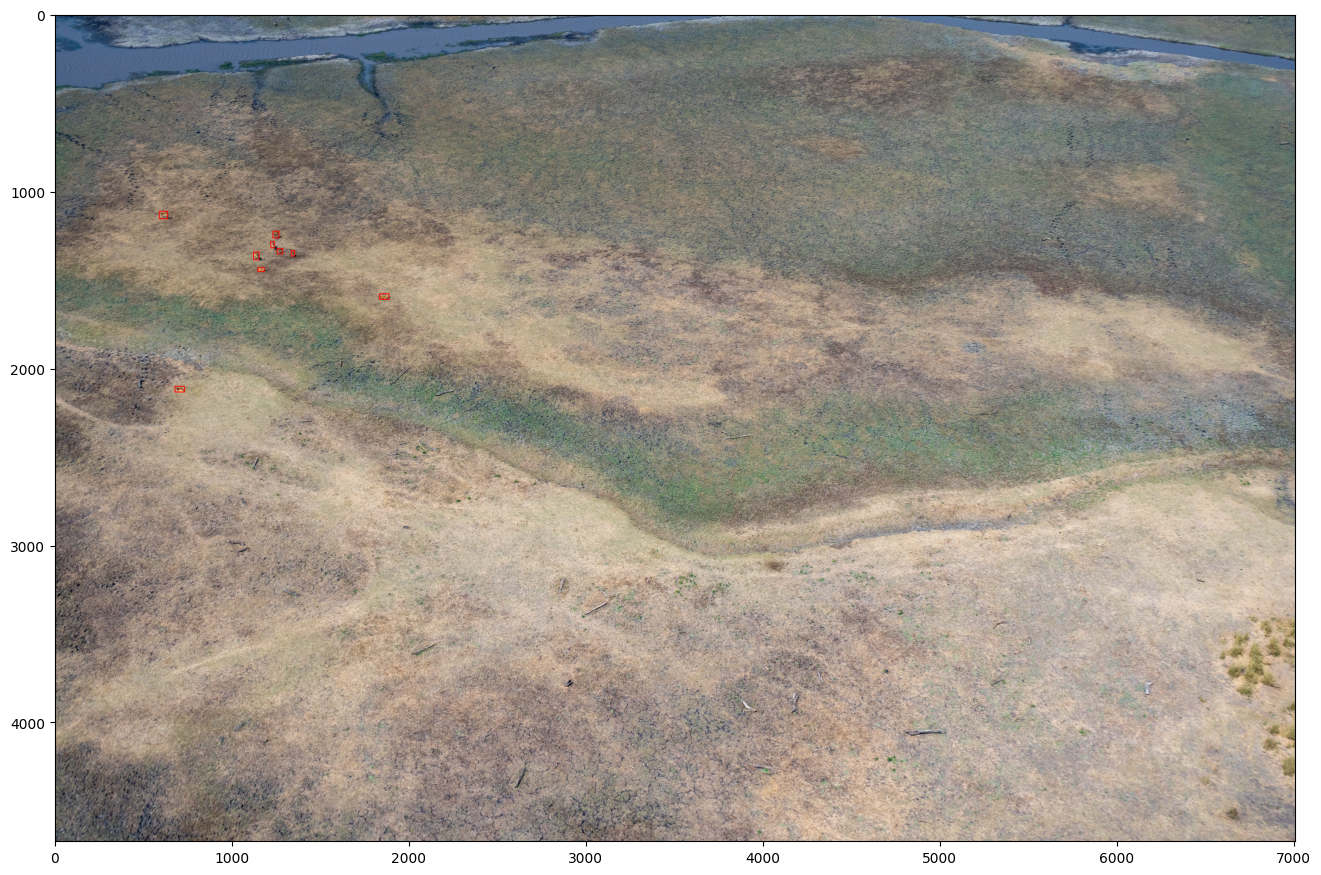

In [17]:
# Randomly sample an image and plot bounding boxes

sample_image_path = df.sample(n=1)['file_path'].values[0]
sample_df = df[df['file_path']==sample_image_path]

plot_bboxes(sample_image_path, \
            sample_df['bbox'][:].values.tolist())

### Decode metadata from filenames

In [18]:
df['survey_code'] = df['file_name'].apply(lambda x: x.split('_')[0])
df['aircraft_registration'] = df['file_name'].apply(lambda x: x.split('_')[1].split('-')[0])
df['camera_side'] = df['file_name'].apply(lambda x: x.split('_')[1].split('-')[1])
df['flight_session'] = df['file_name'].apply(lambda x: x.split('_')[2].split('-')[0])
df['exif_timestamp'] = df['file_name'].apply(lambda x: x.split('_')[2].split('-')[1])
df['orig_file_name'] = df['file_name'].apply(lambda x: x.split('_')[3].split('.')[0])

In [19]:
df['species'] = df['species'].fillna('none')

In [20]:
# 'strat' is a composite variable thas we will try to balance when splitting data in train and test.
# Each combination of all these variables will be optimized to be balanced between train and test splits

df['strat'] = df['survey_code'] + '_' + df['aircraft_registration'] + '_' + df['camera_side']\
+ '_' + df['flight_session']  + '_' + df['species']

<AxesSubplot:>

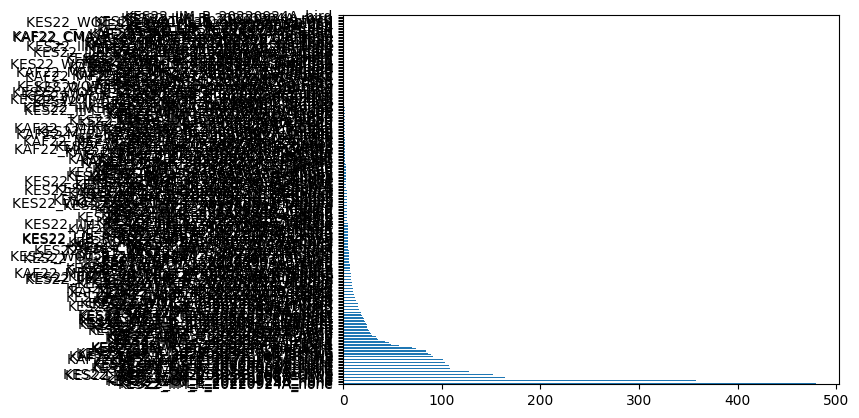

In [21]:
# Splitting will happen on image-level to avoid any soft leaks such as same terrain or visual artifacts.
# Annotations and tiles from each image will all either be in test or in train only.

df_img = df.drop_duplicates(subset=['file_path'])

df_img['strat'].value_counts().plot(kind='barh')

<AxesSubplot:>

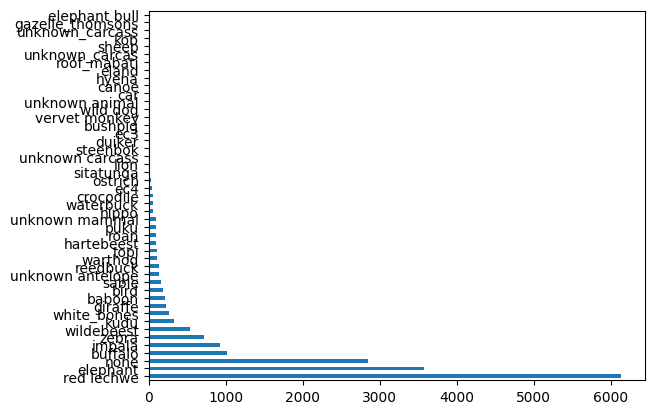

In [23]:
df['species'].value_counts().plot(kind='barh')

<AxesSubplot:>

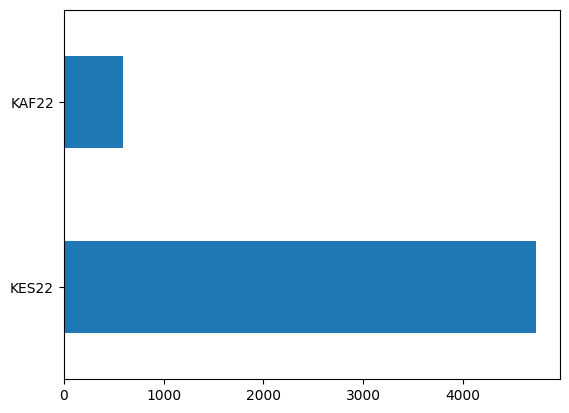

In [24]:
df_img['survey_code'].value_counts().plot(kind='barh')

<AxesSubplot:>

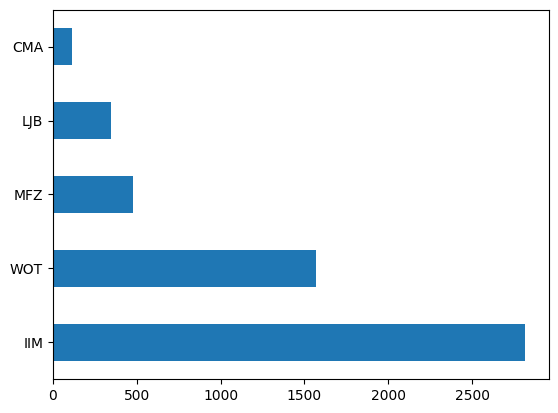

In [25]:
df_img['aircraft_registration'].value_counts().plot(kind='barh')

<AxesSubplot:>

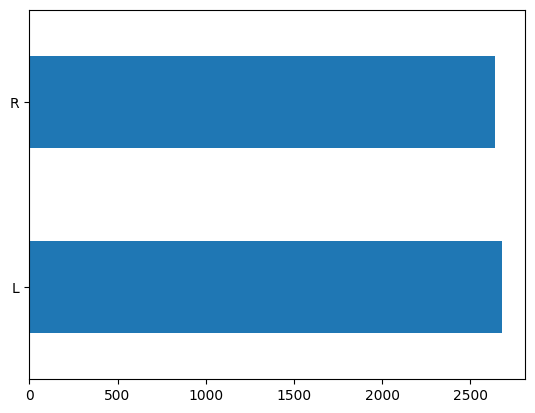

In [26]:
df_img['camera_side'].value_counts().plot(kind='barh')

<AxesSubplot:>

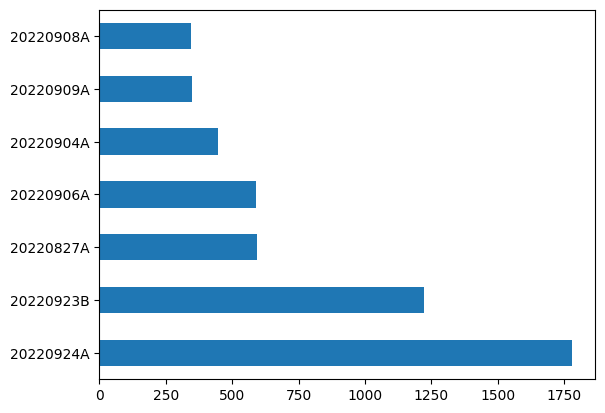

In [27]:
df_img['flight_session'].value_counts().plot(kind='barh')

In [29]:
# Number of annotations in each image
df['annot_count'] = df['file_name'].map(df.groupby('file_name').size() - 1)

df_img = df.drop_duplicates(subset=['file_path'])


<AxesSubplot:>

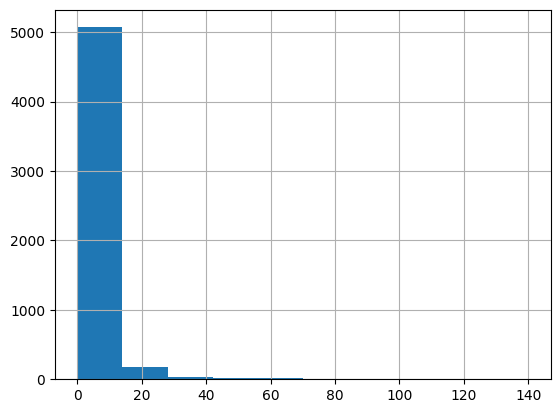

In [30]:
# Distribution of annotations per image

df_img['annot_count'].hist()

<AxesSubplot:>

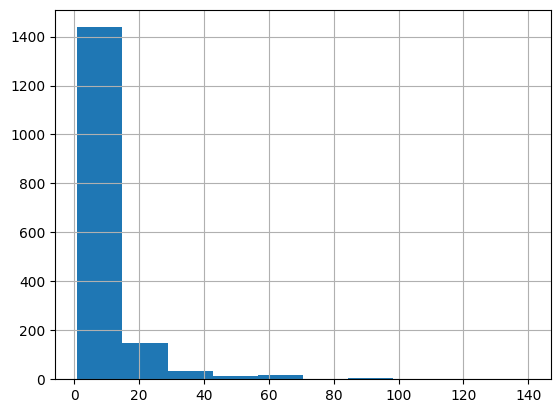

In [31]:
# Distribution of annotations per image for positive images only

df_img_nonzero = df_img[df_img['annot_count'] != 0]
df_img_nonzero['annot_count'].hist()

In [32]:
df = df.reset_index(drop=True)

In [33]:
df['species'].value_counts()

red lechwe          6132
elephant            3579
none                2842
buffalo             1014
impala               924
zebra                723
wildebeest           533
kudu                 325
white_bones          259
giraffe              227
baboon               217
bird                 180
sable                158
unknown antelope     134
reedbuck             127
warthog              108
topi                 101
hartebeest            96
roan                  92
puku                  91
unknown mammal        90
hippo                 62
waterbuck             59
crocodile             52
ec4                   48
ostrich               36
sitatunga             22
lion                  15
unknown carcass       13
steenbok              10
duiker                 9
ec3                    8
bushpig                6
vervet monkey          4
wild dog               4
unknown animal         3
car                    3
canoe                  3
hyena                  2
eland                  2


### Split the data
- The data will be balanced between train and test set on all fields that make up the 'strat' varible 
- All annotations with the same 'file_name' will be placed either in test or train set (aka 'grouped')

In [35]:
import numpy as np
from sklearn.model_selection import StratifiedGroupKFold
X = df.index
y = df['strat'].values
groups = df['file_name'].values
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=0)
sgkf.get_n_splits(X, y)
print(sgkf)
for i, (train_index, test_index) in enumerate(sgkf.split(X, y, groups)):
    break
        
df_train = df.iloc[train_index]
df_test = df.iloc[test_index]

print(len(df_train), len(df_test))

StratifiedGroupKFold(n_splits=5, random_state=0, shuffle=True)


/virtualenv/env3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:880: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


14551 3771


In [37]:
# Number of unique species in train set and test set
# Some species have too few samples, so might not be possible to have them both in the train set and test set.

print('train: ', df_train['species'].nunique())
print('test: ', df_test['species'].nunique())

train:  46
test:  36


In [38]:
df_train_img = df_train.drop_duplicates(subset=['file_path'])
df_test_img = df_test.drop_duplicates(subset=['file_path'])

In [39]:
def nonempty_dist(df_img):
    df_img_nonzero = df_img[df_img['annot_count'] != 0]
    df_img_zero = df_img[df_img['annot_count'] == 0]
    print('Number of nonzero images:', len(df_img_nonzero))
    print('Number of zero images:', len(df_img_zero))
    print('Ratio nonzero/all:', len(df_img_nonzero)/len(df_img))
    df_img_nonzero['annot_count'].hist()
    plt.show()

### Ratio of positive and negative images in the train and test set

- During tiling, in the next notebooks these ratios might be altered further

Number of nonzero images: 1340
Number of zero images: 2918
Ratio nonzero/all: 0.3147017379051198


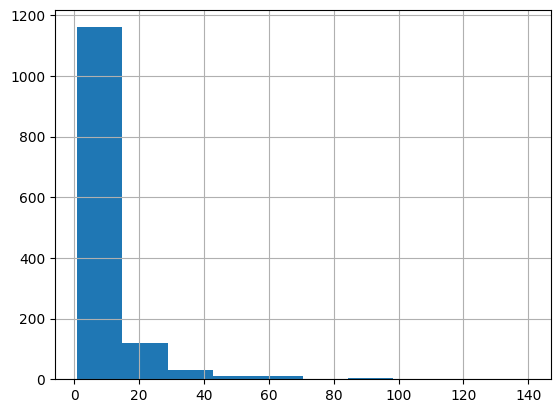

Number of nonzero images: 320
Number of zero images: 744
Ratio nonzero/all: 0.3007518796992481


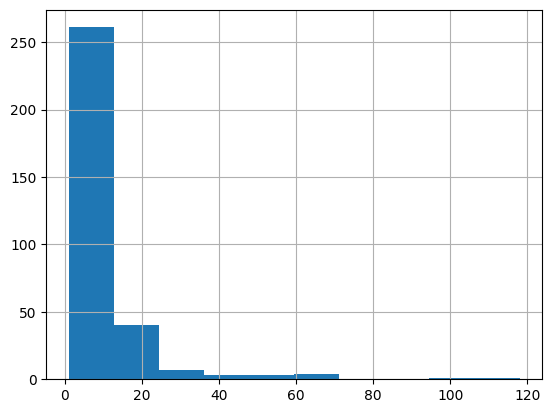

In [42]:
nonempty_dist(df_train_img)
nonempty_dist(df_test_img)

### Checking if the stratified fields are balanced between the train and test set

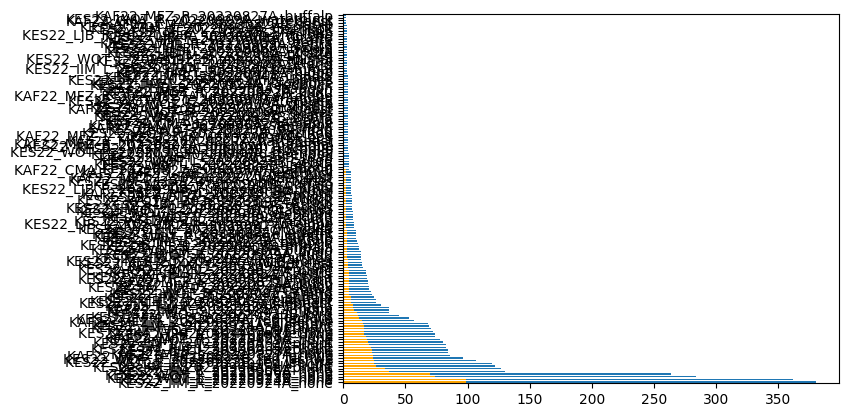

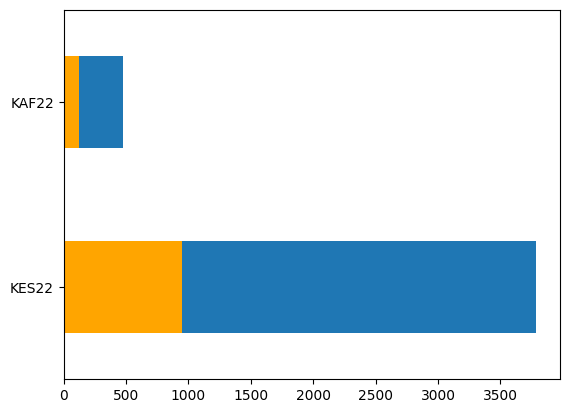

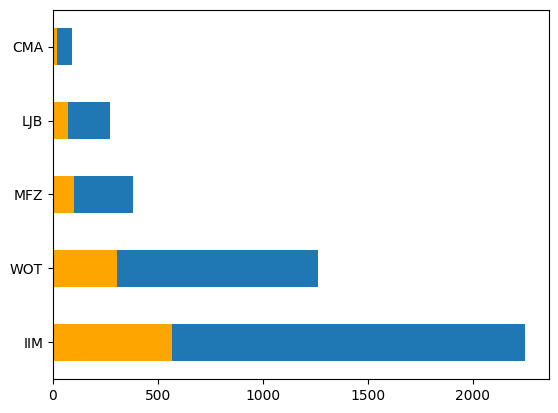

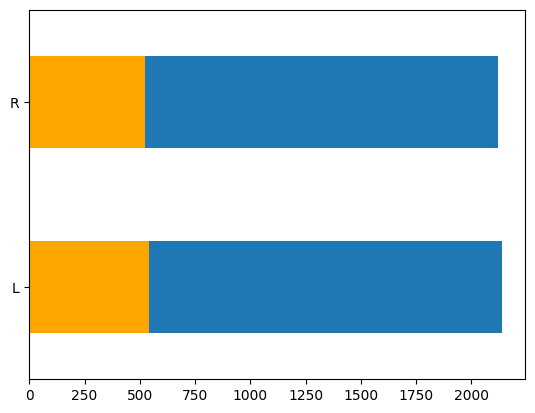

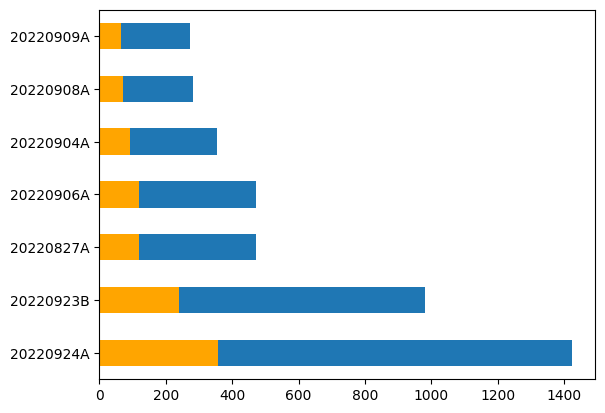

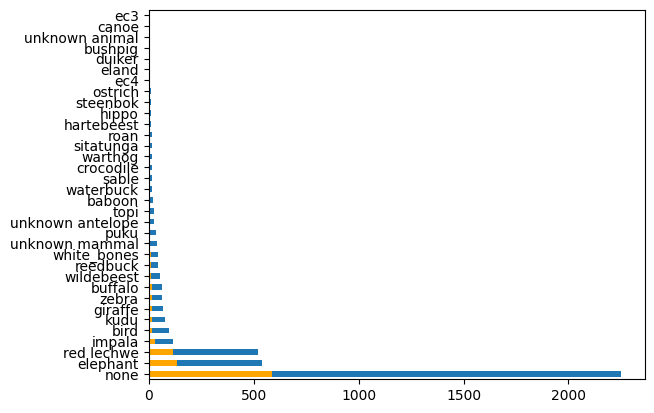

In [43]:
df_train_img['strat'].value_counts().plot(kind='barh')
df_test_img['strat'].value_counts().plot(kind='barh', color='orange')
plt.show()

df_train_img['survey_code'].value_counts().plot(kind='barh')
df_test_img['survey_code'].value_counts().plot(kind='barh', color='orange')
plt.show()


df_train_img['aircraft_registration'].value_counts().plot(kind='barh')
df_test_img['aircraft_registration'].value_counts().plot(kind='barh', color='orange')
plt.show()


df_train_img['camera_side'].value_counts().plot(kind='barh')
df_test_img['camera_side'].value_counts().plot(kind='barh', color='orange')
plt.show()


df_train_img['flight_session'].value_counts().plot(kind='barh')
df_test_img['flight_session'].value_counts().plot(kind='barh', color='orange')
plt.show()

df_train_img['species'].value_counts().plot(kind='barh')
df_test_img['species'].value_counts().plot(kind='barh', color='orange')
plt.show()


In [46]:
len(df_train), len(df_test)

(14551, 3771)

### Export split CSVs

In [202]:
df_train.to_csv('kaza_train_v0.csv')
df_test.to_csv('kaza_test_v0.csv')

14551

### Export images that are part of the CSV to a separate folder

In [ ]:
### Export preprocessed 

export_dir = 'kaza_export_v0'
images_out_dir = f'{export_dir}/images'

os.makedirs(images_out_dir)
df.to_csv(f'{export_dir}/{export_dir}.csv')

for i, row in tqdm(df.iterrows(), total=len(df)):
    file_path = row['file_path']
    shutil.copy2(file_path, images_out_dir)